# Predictive Coding Network PyTorch Implementation

In [1]:
import torch
from pcn import PCN, PCNLayer

### MNIST Preparation

In [2]:
def flatten_image(image):
    return image.reshape(-1)

def unflatten_image(vector, original_shape=(28,28)):
    return vector.reshape(*original_shape)

# Example usage:
# flattened = flatten_image(image)  # [784] for MNIST
# unflattened = unflatten_image(flattened, (1, 28, 28))  # back to [1, 28, 28]

In [3]:
# Import MNIST
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),  # MNIST mean and std
])

# Load training data
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Load test data
test_dataset = datasets.MNIST('./data', train=False, transform=transform)


Visualize the data:

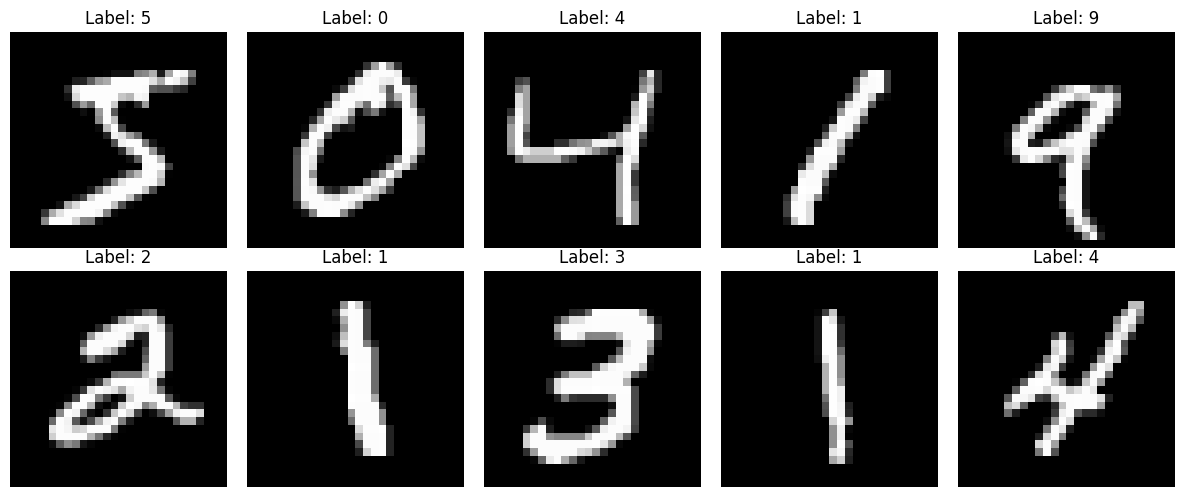

In [4]:
import matplotlib.pyplot as plt


# Create a figure with a grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

# Display 10 random images
for idx in range(10):
    # Unflatten the image back to 28x28 shape
    img = train_dataset[idx][0].squeeze(0)
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f'Label: {train_dataset[idx][1]}')
    axes[idx].axis('off')
plt.tight_layout()
plt.show()


In [5]:
import random
import torch.nn.functional as F
class MNISTDataLoader:
    def __init__(self, dataset, shuffle=True):
        self.dataset = dataset
        self.shuffle = shuffle
        self.indices = list(range(len(dataset)))
        if shuffle:
            random.shuffle(self.indices)
        self.current_idx = 0
        
    def __iter__(self):
        self.current_idx = 0
        if self.shuffle:
            random.shuffle(self.indices)
        return self
    
    def __next__(self):
        if self.current_idx >= len(self.dataset):
            raise StopIteration
            
        item = self.dataset[self.indices[self.current_idx]]
        self.current_idx += 1
        
        # Remove batch dimension and return as tuple
        x = item[0].squeeze(0).reshape(-1)  # Remove batch dim
        y = F.one_hot(torch.tensor(item[1]), num_classes=10).float()
        return x, y
    
    def __len__(self):
        return len(self.dataset)

# Create data loaders
train_loader = MNISTDataLoader(train_dataset)
test_loader = MNISTDataLoader(test_dataset, shuffle=False)




### Discriminator

In [6]:
device = torch.device('cpu')
discriminator = PCN(
    [28*28, 32, 32, 10], # layer sizes
    device=device
)

In [7]:
discriminator.train(
    train_loader=train_loader,
    epochs=1,
    T=10,
    gamma=0.05,
    alpha=0.01,
    forward=True,
    evaluator=lambda x: x.evaluate(test_loader)
)

Epoch 1/1


Training: 100%|██████████| 60000/60000 [01:04<00:00, 924.89it/s]


In [12]:
discriminator.evaluate(test_loader)

0.8124

### Generator

In [8]:
def eval_generator(model):
    for i in range(10):
        y = F.one_hot(torch.tensor(i), num_classes=10).float()
        x = model.generate(y)
        x = x.reshape(28, 28)
        plt.subplot(2, 5, i+1)
        plt.imshow(x.detach().cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.title(f'Digit {i}')

In [9]:
device = torch.device('cpu')
generator = PCN(
    [28*28, 32, 32, 10], # layer sizes
    device=device
)

Epoch 1/1


Training: 100%|██████████| 60000/60000 [01:20<00:00, 743.33it/s]


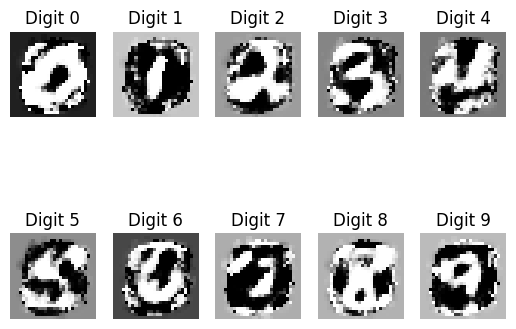

In [10]:
generator.train(
    train_loader=train_loader,
    epochs=1,
    T=10,
    gamma=0.05,
    alpha=0.01,
    forward=False,
    evaluator=eval_generator
)

In [11]:
generator.evaluate(test_loader)

0.394